In [ ]:
# ====================== IMPORT LIBRARIES ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# ====================== LOAD DATA ======================
df = pd.read_csv('/content/Student_Performance.csv')

In [ ]:
# ====================== DATA PREVIEW ======================
print("\n===== Dataset Preview =====")
from IPython.display import display
display(df.head())

print("\n===== Dataset Shape =====")
print(df.shape)

print("\n===== Data Types =====")
print(df.dtypes)

print("\n===== Missing Values =====")
print(df.isnull().sum())

print("\n===== Statistical Summary =====")
display(df.describe())


===== Dataset Preview =====


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0



===== Dataset Shape =====
(10000, 6)

===== Data Types =====
Hours Studied                         int64
Previous Scores                       int64
Extracurricular Activities           object
Sleep Hours                           int64
Sample Question Papers Practiced      int64
Performance Index                   float64
dtype: object

===== Missing Values =====
Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

===== Statistical Summary =====


,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


In [ ]:
# ====================== OUTLIER REMOVAL ======================
Q1 = df['Performance Index'].quantile(0.25)
Q3 = df['Performance Index'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df = df[(df['Performance Index'] >= lower) & (df['Performance Index'] <= upper)]
print("Remaining rows after removing outliers:", df.shape)

Remaining rows after removing outliers: (10000, 6)


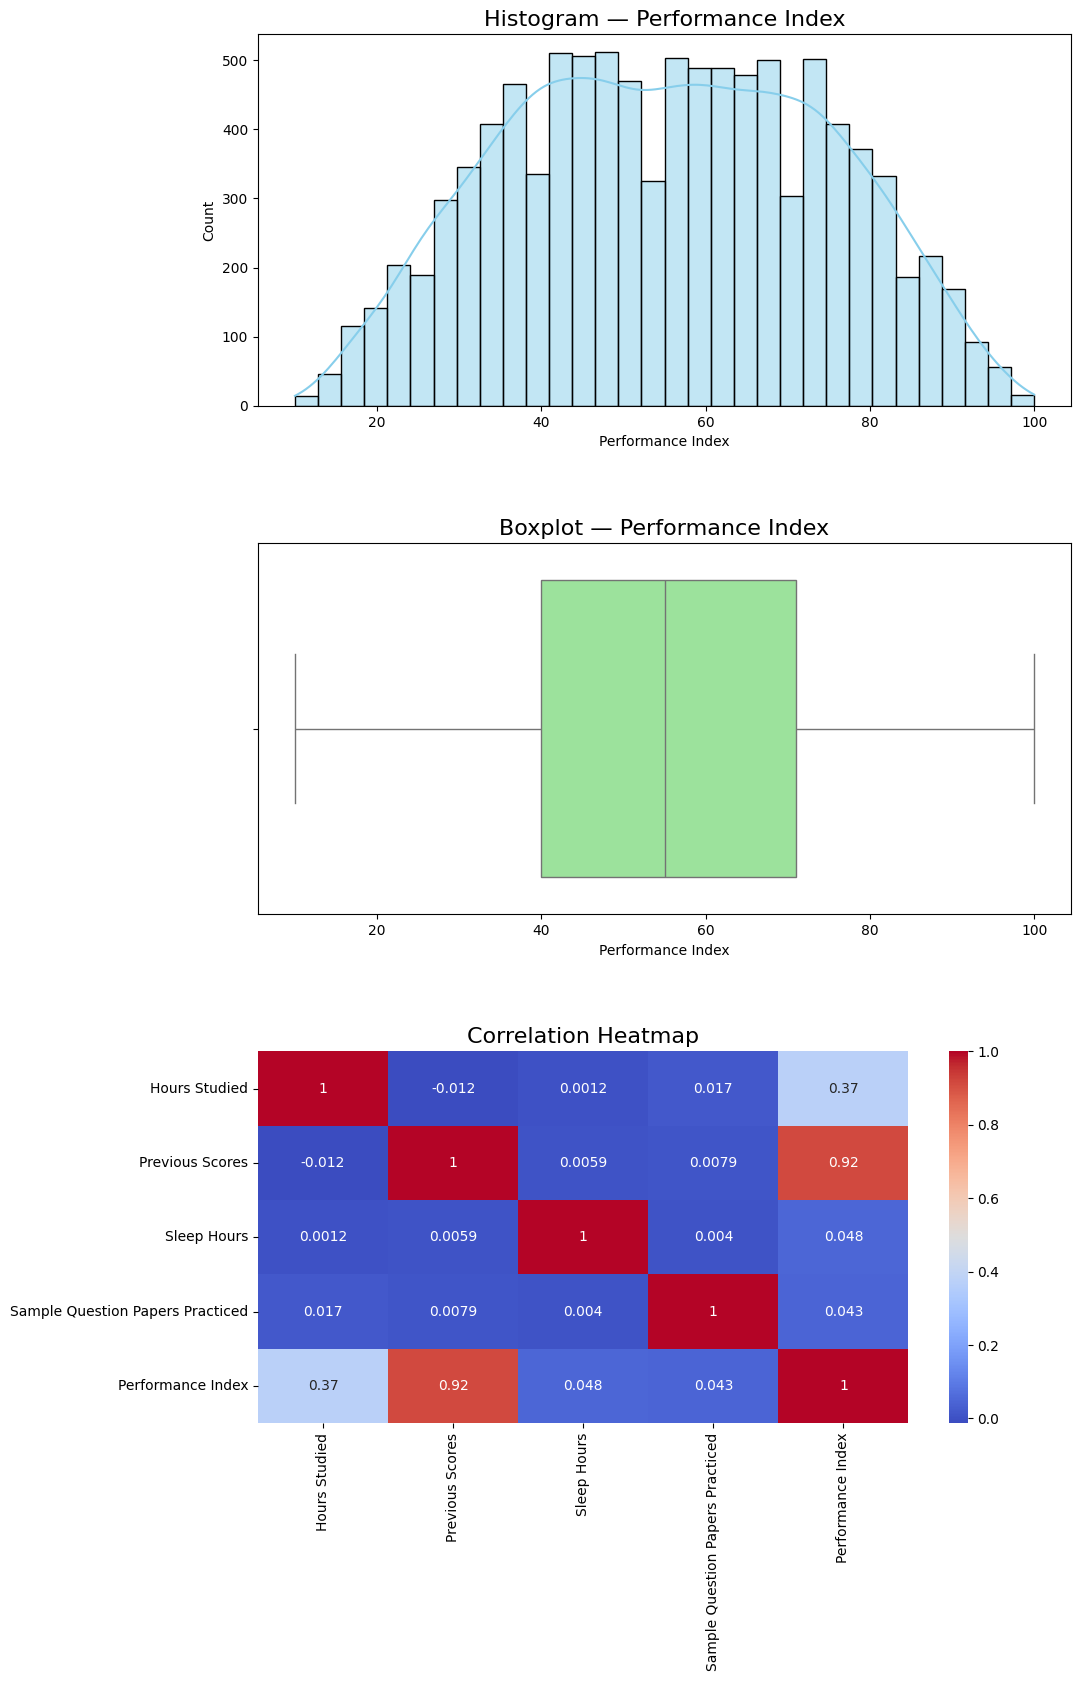

In [ ]:
# ====================== VISUALIZATIONS ======================
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

sns.histplot(df['Performance Index'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title("Histogram — Performance Index", fontsize=16)

sns.boxplot(x=df['Performance Index'], ax=axes[1], color='lightgreen')
axes[1].set_title("Boxplot — Performance Index", fontsize=16)

sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", ax=axes[2])
axes[2].set_title("Correlation Heatmap", fontsize=16)

fig.tight_layout(pad=5.0)
plt.show()

In [ ]:
# ====================== PREPROCESSING ======================
encoder = LabelEncoder()
df['Extracurricular Activities'] = encoder.fit_transform(df['Extracurricular Activities'])

feature_cols = list(df.drop('Performance Index', axis=1).columns)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop('Performance Index', axis=1))

X = pd.DataFrame(scaled_features, columns=feature_cols)
y = df['Performance Index']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# ====================== MODEL 1 — LINEAR REGRESSION ======================
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pred = lr_model.predict(x_test)

print("\n===== Linear Regression Results =====")
print("MSE :", mean_squared_error(y_test, lr_pred))
print("R²  :", r2_score(y_test, lr_pred))
print("Train Score:", lr_model.score(x_train, y_train) * 100)
print("Test Score :", lr_model.score(x_test, y_test) * 100)

# ====================== MODEL 2 — RANDOM FOREST + GRIDSEARCH ======================
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15]
}

rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=5, scoring='r2')
rf_grid.fit(x_train, y_train)

rf_best_model = rf_grid.best_estimator_
rf_pred = rf_best_model.predict(x_test)

print("\n===== Random Forest Results (Optimized) =====")
print("Best Params:", rf_grid.best_params_)
print("MSE :", mean_squared_error(y_test, rf_pred))
print("R²  :", r2_score(y_test, rf_pred))
print("Train Score:", rf_best_model.score(x_train, y_train) * 100)
print("Test Score :", rf_best_model.score(x_test, y_test) * 100)

# ====================== MODEL 3 — SVR (RBF KERNEL) ======================
svr = SVR(kernel='rbf')
svr.fit(x_train, y_train)
y_pred_svr = svr.predict(x_test)

print("\n===== SVR (RBF Kernel) =====")
print("MSE :", mean_squared_error(y_test, y_pred_svr))
print("R²  :", r2_score(y_test, y_pred_svr))
print("Train Score:", svr.score(x_train, y_train) * 100)
print("Test Score :", svr.score(x_test, y_test) * 100)

# ====================== MODEL 4 — KNN (FIND BEST k FIRST) ======================
param_grid = {'n_neighbors': list(range(1, 21))}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid_search.fit(x_train, y_train)
best_k = grid_search.best_params_['n_neighbors']

nn_model = KNeighborsRegressor(n_neighbors=best_k)
nn_model.fit(x_train, y_train)
nn_pred = nn_model.predict(x_test)

print("\n===== KNN Results =====")
print("MSE :", mean_squared_error(y_test, nn_pred))
print("R²  :", r2_score(y_test, nn_pred))
print("Train Score:", nn_model.score(x_train, y_train) * 100)
print("Test Score :", nn_model.score(x_test, y_test) * 100)


===== Linear Regression Results =====
MSE : 4.082628398521855
R²  : 0.9889832909573145
Train Score: 98.86898790682355
Test Score : 98.89832909573146

===== Random Forest Results (Optimized) =====
Best Params: {'n_estimators': 300}
MSE : 5.133261885191025
R²  : 0.9861482243523482
Train Score: 99.74989254725298
Test Score : 98.61482243523481

===== SVR (RBF Kernel) =====
MSE : 5.420930575787763
R²  : 0.9853719689708538
Train Score: 98.56651648933654
Test Score : 98.53719689708538

===== KNN Results =====
MSE : 8.3449737654321
R²  : 0.9774816272830771
Train Score: 97.97783075783302
Test Score : 97.7481627283077


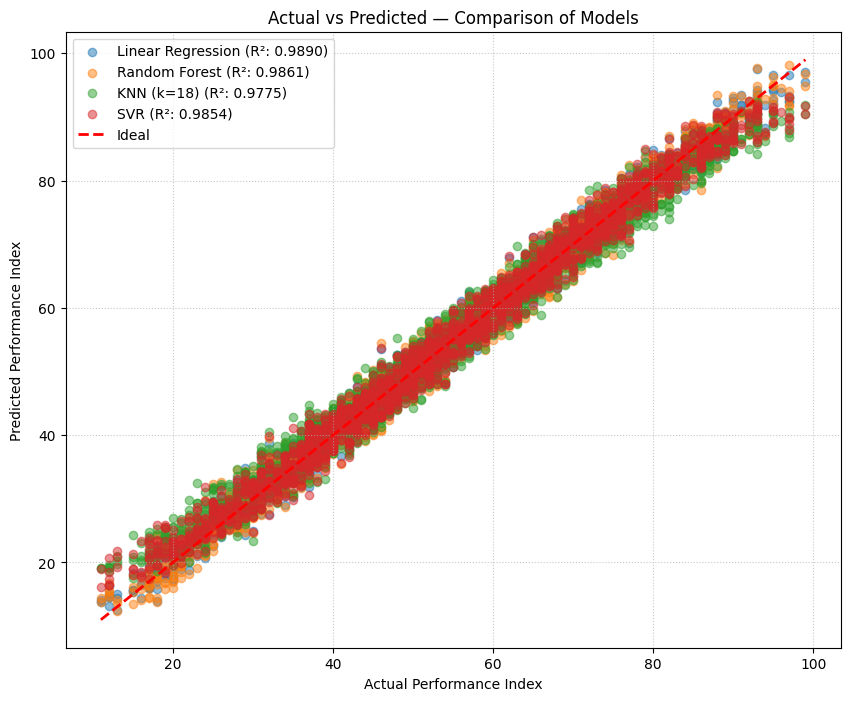

In [ ]:
# ====================== ACTUAL VS PREDICTED PLOT ======================
plt.figure(figsize=(10, 8))

plt.scatter(y_test, lr_pred, alpha=0.5, label=f"Linear Regression (R²: {r2_score(y_test, lr_pred):.4f})")
plt.scatter(y_test, rf_pred, alpha=0.5, label=f"Random Forest (R²: {r2_score(y_test, rf_pred):.4f})")
plt.scatter(y_test, nn_pred, alpha=0.5, label=f"KNN (k={best_k}) (R²: {r2_score(y_test, nn_pred):.4f})")
plt.scatter(y_test, y_pred_svr, alpha=0.5, label=f"SVR (R²: {r2_score(y_test, y_pred_svr):.4f})")

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color="red", linestyle='--', linewidth=2, label="Ideal")

plt.xlabel("Actual Performance Index")
plt.ylabel("Predicted Performance Index")
plt.title("Actual vs Predicted — Comparison of Models")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()